In [7]:
import numpy as np
def render_event_voxels(event_stream):
    T, H, W = event_stream.shape
    img_outs = []
    img_0_inds = []
    img_pos_inds = []
    img_neg_inds = []
    for t in range(T):
        img_acc = event_stream[t]
        img_out = np.full((H,W,3), fill_value=255,dtype='uint8')

        # Simple thresholding
        #img_out[img_acc > 0] = [0,0,255]
        #img_out[img_acc < 0] = [255,0,0]

        # With weighting (more complicated alternative)
        clip_percentile = 80
        min_percentile = -np.percentile(np.abs(img_acc[img_acc < 0]), clip_percentile)
        max_percentile = np.percentile(np.abs(img_acc[img_acc > 0]), clip_percentile)
        img_acc = np.clip(img_acc, min_percentile, max_percentile)


        img_acc_max = img_acc.max()
        idx_pos = img_acc > 0
        img_acc[idx_pos] = img_acc[idx_pos]/img_acc_max
        val_pos = img_acc[idx_pos]
        img_out[idx_pos] = np.stack((255-val_pos*255, 255-val_pos*255, np.ones_like(val_pos)*255), axis=1)

        img_acc_min = img_acc.min()
        idx_neg = img_acc < 0
        img_acc[idx_neg] = img_acc[idx_neg]/img_acc_min
        val_neg = img_acc[idx_neg]
        img_out[idx_neg] = np.stack((np.ones_like(val_neg)*255, 255-val_neg*255, 255-val_neg*255), axis=1)
        img_outs.append(img_out)

        idx_zero = img_acc == 0

        img_0_inds.append(idx_zero)
        img_pos_inds.append(idx_pos)
        img_neg_inds.append(idx_neg)
    return img_outs, np.array(img_0_inds), np.array(img_pos_inds), np.array(img_neg_inds)

In [8]:
def cal_single_iou(pred, gt):
    keep = gt != 255
    hist = np.bincount(gt[keep] * 11 + pred[keep], minlength=11**2).reshape(11,11)
    ious = np.diag(hist) / (hist.sum(0) + hist.sum(1) - np.diag(hist))
    # ious[np.isnan(ious)] = 0.
    miou = ious.mean()
    ious *= 100
    miou *= 100
    return ious, miou

In [10]:
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

semseg_dict = {
    "num_classes": 11,
    "ignore_label": 255,
    "class_names": [
        "background", "building", "fence", "person", "pole",
        "road", "sidewalk", "vegetation", "car", "wall",
        "traffic sign",
    ],
    "color_map": np.array([
        [0, 0, 0], [70, 70, 70], [190, 153, 153], [220, 20, 60], [153, 153, 153], 
        [128, 64, 128], [244, 35, 232], [107, 142, 35], [0, 0, 142], [102, 102, 156], 
        [220, 220, 0],
    ]),
}
# scenes = ['day', 'night']
scenes = ['day']
# splits = ['train', 'val']
splits = ['val']
rgb_day_dir = Path('/home/xiaoshan/work/adap_v/DELIVER/output/DSEC_CMNeXt-B2_i/dsec_rgb_day_eval_20240927_120256')
rgbe_day_dir = Path('/home/xiaoshan/work/adap_v/DELIVER/output/DSEC_CMNeXt-B2_ie/dsec_rgbe_day_eval_20240927_120221') 

results = {}
results['rgb'] = {}
results['rgbe'] = {}
for scene in scenes:
    for split in splits:
        data_path = Path(f'/home/xiaoshan/work/adap_v/my_proj/data/DSEC/{scene}/')
        event_03_dir = data_path / 'event_03' / split
        img_dir = data_path / 'leftImg8bit' / split
        lbl_dir = data_path / 'gtFine' / split
        
        seqs = sorted(list(event_03_dir.glob('*')))
        for seq in seqs:
            seq = str(seq.relative_to(event_03_dir))
            print("Processing sequence: ", seq)
            seq_event_03_dir = data_path / 'event_03' / split / seq

            for event_03_file in tqdm(sorted(seq_event_03_dir.glob('*.npy'))):
                event_03_file_str = str(event_03_file)
                img_file = Path(event_03_file_str.replace('event_03', 'leftImg8bit').replace('.npy', '.png'))
                lbl_file = Path(event_03_file_str.replace('event_03', 'gtFine').replace('.npy', '_gtFine_labelTrainIds11.png'))
                rgb_day_file_id = rgb_day_dir / seq / str(event_03_file.relative_to(seq_event_03_dir)).replace('.npy', '.png')
                rgb_day_file_color = rgb_day_dir / seq / str(event_03_file.relative_to(seq_event_03_dir)).replace('.npy', '_labelTrainIds11.png')
                rgbe_day_file_id = rgbe_day_dir / seq / str(event_03_file.relative_to(seq_event_03_dir)).replace('.npy', '.png')
                rgbe_day_file_color = rgbe_day_dir / seq / str(event_03_file.relative_to(seq_event_03_dir)).replace('.npy', '_labelTrainIds11.png')

                event_03 = np.load(event_03_file)[:, :440, :]
                # event_03 = np.transpose(event_03, (1, 2, 0))  # 使用 numpy.transpose 替代 permute
                rendered_events, img_0_inds, img_pos_inds, img_neg_inds = render_event_voxels(event_03) 
                img = Image.open(img_file)
                lbl_id = Image.open(lbl_file)
                lbl_color = semseg_dict['color_map'][np.array(lbl_id)]
                rgb_day_id = Image.open(rgb_day_file_id)
                rgb_day_color = Image.open(rgb_day_file_color)
                rgbe_day_id = Image.open(rgbe_day_file_id)
                rgbe_day_color = Image.open(rgbe_day_file_color)

                rgb_iou, rgb_miou = cal_single_iou(np.array(rgb_day_id), np.array(lbl_id))
                rgbe_iou, rgbe_miou = cal_single_iou(np.array(rgbe_day_id), np.array(lbl_id))
                # print(f'RGB: {rgb_miou:.2f}, RGBE: {rgbe_miou:.2f}')
                # print(f'RGB: {rgb_iou}, RGBE: {rgbe_iou}')
                results['rgb'][f'{seq}_{event_03_file.stem}'] = {}
                results['rgbe'][f'{seq}_{event_03_file.stem}'] = {}
                results['rgb'][f'{seq}_{event_03_file.stem}']['miou'] = rgb_miou
                results['rgbe'][f'{seq}_{event_03_file.stem}']['miou'] = rgbe_miou
                results['rgb'][f'{seq}_{event_03_file.stem}']['iou'] = rgb_iou
                results['rgbe'][f'{seq}_{event_03_file.stem}']['iou'] = rgbe_iou

    #             # 如果任意一个的 miou 小于 50，可视化
    #             if rgb_miou > 50 and rgbe_miou > 50:
    #                 continue
    #             print('Visualizing...')

    #             lbl_color = Image.fromarray(lbl_color.astype(np.uint8))
                
    #             # 可视化事件图像
    #             fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    #             # 第一行
    #             axes[0, 0].imshow(rendered_events[-1])
    #             axes[0, 0].set_title('Rendered Events')
    #             axes[0, 1].imshow(img)
    #             axes[0, 1].set_title('Image')
    #             axes[0, 2].imshow(lbl_color)
    #             axes[0, 2].set_title('Label')

    #             # 第二行
    #             axes[1, 0].imshow(img)
    #             axes[1, 0].imshow(rendered_events[-1], alpha=0.7)
    #             axes[1, 0].set_title('Overlay Image and Events')
    #             axes[1, 1].imshow(img)
    #             axes[1, 1].imshow(lbl_color, alpha=0.7)
    #             axes[1, 1].set_title('Overlay Image and Label')
    #             axes[1, 2].imshow(img)
    #             axes[1, 2].imshow(rendered_events[-1], alpha=0.7)
    #             axes[1, 2].imshow(lbl_color, alpha=0.7)
    #             axes[1, 2].set_title('Overlay Image, Events and Label')

    #             # 第三行
    #             axes[2, 0].imshow(rgb_day_color)
    #             axes[2, 0].set_title('RGB Day Color')
    #             axes[2, 1].imshow(rgbe_day_color)
    #             axes[2, 1].set_title('RGBE Day Color')
    #             axes[2, 2].imshow(rgbe_day_color, alpha=0.7)
    #             axes[2, 2].imshow(rendered_events[-1], alpha=0.5)
    #             axes[2, 2].set_title('Overlay Events and RGBE Day Color')
    #             # tight layout
    #             plt.tight_layout()
    #             plt.savefig(f'./visualize/{seq}_{event_03_file.stem}.png')

    #             break
    #         break
    #     break
    # break

Processing sequence:  zurich_city_13_a


 21%|██▏       | 9/42 [00:00<00:02, 14.09it/s]/tmp/ipykernel_1225835/1448291431.py:4: RuntimeWarning: invalid value encountered in true_divide
  ious = np.diag(hist) / (hist.sum(0) + hist.sum(1) - np.diag(hist))
100%|██████████| 42/42 [00:02<00:00, 16.88it/s]


Processing sequence:  zurich_city_14_c


100%|██████████| 133/133 [00:07<00:00, 18.58it/s]


Processing sequence:  zurich_city_15_a


100%|██████████| 138/138 [00:08<00:00, 16.87it/s]


In [17]:
nan_classes = []
# 遍历 results['rgb'] 中的每个项目
for class_name, metrics in results['rgb'].items():
    # 检查是否有 NaN
    if np.isnan(metrics['miou']):
        for key, value in metrics.items():
            print(f"RGB: {class_name} {key}: {value}")
        nan_classes.append(class_name)

# 输出所有出现过 NaN 的类别
print("出现过 NaN 的类别有:", nan_classes)

类别 zurich_city_13_a_000101 出现过 NaN
类别 zurich_city_13_a_000110 出现过 NaN
类别 zurich_city_13_a_000155 出现过 NaN
类别 zurich_city_13_a_000182 出现过 NaN
类别 zurich_city_13_a_000218 出现过 NaN
类别 zurich_city_13_a_000227 出现过 NaN
类别 zurich_city_13_a_000236 出现过 NaN
类别 zurich_city_13_a_000245 出现过 NaN
类别 zurich_city_13_a_000263 出现过 NaN
类别 zurich_city_13_a_000272 出现过 NaN
类别 zurich_city_13_a_000290 出现过 NaN
类别 zurich_city_13_a_000299 出现过 NaN
类别 zurich_city_13_a_000308 出现过 NaN
类别 zurich_city_13_a_000326 出现过 NaN
类别 zurich_city_14_c_000164 出现过 NaN
类别 zurich_city_14_c_000173 出现过 NaN
类别 zurich_city_14_c_000200 出现过 NaN
类别 zurich_city_14_c_000218 出现过 NaN
类别 zurich_city_14_c_000380 出现过 NaN
类别 zurich_city_14_c_000479 出现过 NaN
类别 zurich_city_14_c_000542 出现过 NaN
类别 zurich_city_14_c_000551 出现过 NaN
类别 zurich_city_14_c_000560 出现过 NaN
类别 zurich_city_14_c_000569 出现过 NaN
类别 zurich_city_14_c_000578 出现过 NaN
类别 zurich_city_14_c_000614 出现过 NaN
类别 zurich_city_14_c_000632 出现过 NaN
类别 zurich_city_14_c_000641 出现过 NaN
类别 zurich_city_14_c_

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score

def error_analysis_per_image(pred_labels, gt_labels, num_classes):
    """
    Perform error analysis for each image in the batch.
    
    Args:
        pred_labels (numpy array): Predicted labels of shape (batch_size, H, W).
        gt_labels (numpy array): Ground truth labels of shape (batch_size, H, W).
        num_classes (int): Number of classes in the segmentation task.
    
    Returns:
        all_analysis (list): A list of dictionaries, each containing error metrics for one image.
    """
    batch_size = pred_labels.shape[0]
    all_analysis = []  # To store analysis results for each image
    
    for i in range(batch_size):
        pred_label = pred_labels[i].flatten()
        gt_label = gt_labels[i].flatten()

        # Calculate overall accuracy
        pixel_accuracy = np.mean(pred_label == gt_label)

        # Calculate per-class IoU (Intersection over Union)
        iou_per_class = []
        for class_id in range(num_classes):
            intersection = np.sum((pred_label == class_id) & (gt_label == class_id))
            union = np.sum((pred_label == class_id) | (gt_label == class_id))
            if union == 0:
                iou_per_class.append(float('nan'))  # Handle edge case where no ground truth for this class
            else:
                iou_per_class.append(intersection / union)

        # Mean IoU (ignoring NaN values for classes that don't appear)
        mean_iou = np.nanmean(iou_per_class)

        # Confusion matrix
        conf_matrix = confusion_matrix(gt_label, pred_label, labels=np.arange(num_classes))

        # Precision, Recall, and F1-Score
        precision = precision_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)
        recall = recall_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)
        f1 = f1_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)

        # Per-class Jaccard Score (IoU)
        jaccard_per_class = jaccard_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)

        # Create the results dictionary for the current image
        analysis_dict = {
            "Pixel Accuracy": pixel_accuracy,
            "Mean IoU": mean_iou,
            "IoU per class": iou_per_class,
            "Confusion Matrix": conf_matrix,
            "Precision per class": precision,
            "Recall per class": recall,
            "F1 Score per class": f1,
            "Jaccard Score per class (IoU)": jaccard_per_class
        }
        
        # Append the current image's analysis to the list
        all_analysis.append(analysis_dict)
    
    return all_analysis

/home/xiaoshan/miniconda3/envs/cmnext/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import numpy as np
def render_event_voxels(event_stream):
    T, H, W = event_stream.shape
    img_outs = []
    img_0_inds = []
    img_pos_inds = []
    img_neg_inds = []
    for t in range(T):
        img_acc = event_stream[t]
        img_out = np.full((H,W,3), fill_value=255,dtype='uint8')

        # Simple thresholding
        #img_out[img_acc > 0] = [0,0,255]
        #img_out[img_acc < 0] = [255,0,0]

        # With weighting (more complicated alternative)
        clip_percentile = 80
        min_percentile = -np.percentile(np.abs(img_acc[img_acc < 0]), clip_percentile)
        max_percentile = np.percentile(np.abs(img_acc[img_acc > 0]), clip_percentile)
        img_acc = np.clip(img_acc, min_percentile, max_percentile)


        img_acc_max = img_acc.max()
        idx_pos = img_acc > 0
        img_acc[idx_pos] = img_acc[idx_pos]/img_acc_max
        val_pos = img_acc[idx_pos]
        img_out[idx_pos] = np.stack((255-val_pos*255, 255-val_pos*255, np.ones_like(val_pos)*255), axis=1)

        img_acc_min = img_acc.min()
        idx_neg = img_acc < 0
        img_acc[idx_neg] = img_acc[idx_neg]/img_acc_min
        val_neg = img_acc[idx_neg]
        img_out[idx_neg] = np.stack((np.ones_like(val_neg)*255, 255-val_neg*255, 255-val_neg*255), axis=1)
        img_outs.append(img_out)

        idx_zero = img_acc == 0

        img_0_inds.append(idx_zero)
        img_pos_inds.append(idx_pos)
        img_neg_inds.append(idx_neg)
    return img_outs, np.array(img_0_inds), np.array(img_pos_inds), np.array(img_neg_inds)

In [5]:
# 高亮显示不同的部分
def highlight_differences(label1, label2):
    # 比较两张彩色图像，找到不同的像素
    differences = np.any(label1 != label2, axis=-1)  # 在每个像素点比较三个通道
    
    # 创建一个复制的图像，用于标记不同部分
    highlighted_image = label1.copy()
    
    # 将不同的部分标记为荧光绿色（[0, 255, 0]）
    highlighted_image[differences] = [0, 255, 0]
    
    return highlighted_image

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score

def error_analysis_single_image(pred_label, gt_label, num_classes):
    """
    Perform error analysis for a single image.
    
    Args:
        pred_label (numpy array): Predicted label of shape (H, W).
        gt_label (numpy array): Ground truth label of shape (H, W).
        num_classes (int): Number of classes in the segmentation task.
    
    Returns:
        analysis_dict (dict): A dictionary containing error metrics for the image.
    """
    # Flatten the labels
    pred_label = pred_label.flatten()
    gt_label = gt_label.flatten()

    # Calculate overall accuracy
    pixel_accuracy = np.mean(pred_label == gt_label)

    # Calculate per-class IoU (Intersection over Union)
    iou_per_class = []
    for class_id in range(num_classes):
        intersection = np.sum((pred_label == class_id) & (gt_label == class_id))
        union = np.sum((pred_label == class_id) | (gt_label == class_id))
        if union == 0:
            iou_per_class.append(float('nan'))  # Handle edge case where no ground truth for this class
        else:
            iou_per_class.append(intersection / union)

    # Mean IoU (ignoring NaN values for classes that don't appear)
    mean_iou = np.nanmean(iou_per_class)
    # print(mean_iou)

    # Confusion matrix
    conf_matrix = confusion_matrix(gt_label, pred_label, labels=np.arange(num_classes))

    # Precision, Recall, and F1-Score
    precision = precision_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)
    recall = recall_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)
    f1 = f1_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)

    # Per-class Jaccard Score (IoU)
    jaccard_per_class = jaccard_score(gt_label, pred_label, average=None, labels=np.arange(num_classes), zero_division=0)

    # Create the results dictionary
    analysis_dict = {
        "Pixel Accuracy": pixel_accuracy,
        "Mean IoU": mean_iou,
        "IoU per class": iou_per_class,
        "Confusion Matrix": conf_matrix,
        "Precision per class": precision,
        "Recall per class": recall,
        "F1 Score per class": f1,
        "Jaccard Score per class (IoU)": jaccard_per_class
    }
    
    return analysis_dict

# # Example usage:
# # Assuming you have your predicted label and ground truth label as numpy arrays
# pred_label = np.random.randint(0, 3, (256, 256))  # Example prediction
# gt_label = np.random.randint(0, 3, (256, 256))    # Example ground truth

# num_classes = 3  # Assume 3 classes in segmentation
# analysis_result = error_analysis_single_image(pred_label, gt_label, num_classes)

# # Print results
# for metric, result in analysis_result.items():
#     print(f"{metric}: {result}")


In [7]:
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

semseg_dict = {
    "num_classes": 11,
    "ignore_label": 255,
    "class_names": [
        "background", "building", "fence", "person", "pole",
        "road", "sidewalk", "vegetation", "car", "wall",
        "traffic sign",
    ],
    "color_map": np.array([
        [0, 0, 0], [70, 70, 70], [190, 153, 153], [220, 20, 60], [153, 153, 153], 
        [128, 64, 128], [244, 35, 232], [107, 142, 35], [0, 0, 142], [102, 102, 156], 
        [220, 220, 0],
    ]),
}
scenes = ['day']
# scenes = ['day', 'night']
splits = ['val']
# splits = ['train', 'val']
interval = 50

root = Path('/home/xiaoshan/work/adap_v/my_proj/data/DSEC/dsec_anytime')
output_root = Path('/home/xiaoshan/work/adap_v/DELIVER/output/DSEC_CMNeXt-B2_i/dsec_rgb_day_eval_20241021_200305')
results_ = {}
for scene in scenes:
    for split in splits:
        data_path = root / scene
        event_20_dir = data_path / f'startF1_img_event_{interval}ms/event_20' / split
        seqs = sorted(list(os.listdir(event_20_dir)))

        for seq in seqs:
            event_20_dir_ = event_20_dir / seq
            print("Processing sequence: ", seq)

            for event_20_file in tqdm(sorted(event_20_dir_.glob('*.npy'))):
                event_20_file_str = str(event_20_file)
                ori_index = int(event_20_file_str.split('/')[-1].split('.')[0])
                next_index = ori_index + int(interval/50)

                img_next_file = data_path / 'leftImg8bit_next' / split / seq / f'{next_index:06d}.png'
                lbl_next_file = data_path / 'gtFine_next' / split / seq / f'{next_index:06d}_gtFine_labelTrainIds11.png'
                lbl_curr_file = data_path / 'gtFine_cur' / split / seq / f'{ori_index:06d}_gtFine_labelTrainIds11.png'
                pred_next_file = output_root / seq / f'{ori_index:06d}_labelTrainIds11.png'
                flow_file = data_path / 'flow' / split / seq / f'{ori_index:06d}.png'

                event_20 = np.load(event_20_file)[:, :440, :]
                # event_03 = np.transpose(event_03, (1, 2, 0))  # 使用 numpy.transpose 替代 permute
                rendered_events, img_0_inds, img_pos_inds, img_neg_inds = render_event_voxels(event_20) 
                img_next = Image.open(img_next_file)
                flow = Image.open(flow_file)
                flow = np.array(flow)[440:]
                lbl_next = Image.open(lbl_next_file)
                lbl_next = np.array(lbl_next)
                lbl_next_color = semseg_dict['color_map'][lbl_next]
                lbl_next_color = Image.fromarray(lbl_next_color.astype(np.uint8))
                pred_next = Image.open(pred_next_file)
                pred_next = np.array(pred_next)
                pred_next_color = semseg_dict['color_map'][pred_next]
                pred_next_color = Image.fromarray(pred_next_color.astype(np.uint8)
                                                 )
                lbl_cur = Image.open(lbl_curr_file)
                lbl_cur_color = semseg_dict['color_map'][np.array(lbl_cur)]
                lbl_cur_color = Image.fromarray(lbl_cur_color.astype(np.uint8))
                analysis_results_per_image = error_analysis_single_image(pred_next, lbl_next, 11)
                results_[f'{seq}_{event_20_file.stem}'] = analysis_results_per_image
                # # print(event_20.shape, rendered_events[-1].shape, np.array(img_next).shape, np.array(lbl_next_color).shape)
                # # 可视化事件图像
                # fig, axes = plt.subplots(3, 3, figsize=(20, 12))
                # axes[0, 0].imshow(img_next)
                # axes[0, 0].set_title('Image Next')
                # axes[0, 1].imshow(lbl_next_color)
                # axes[0, 1].set_title('Label Next')
                # axes[0, 2].imshow(pred_next_color)
                # axes[0, 2].set_title('Predction Next')
                # axes[1, 0].imshow(img_next)
                # axes[1, 0].imshow(rendered_events[-1], alpha=0.7)
                # axes[1, 0].set_title('Overlay Image and Events')
                # axes[1, 1].imshow(highlight_differences(np.array(lbl_next_color), np.array(lbl_cur_color)))
                # axes[1, 1].set_title('Label Current and Next difference')
                # axes[1, 2].imshow(highlight_differences(np.array(pred_next_color), np.array(lbl_cur_color)))
                # axes[1, 2].set_title('Prediction Next and Current difference')
                # axes[2, 0].imshow(flow)
                # axes[2, 0].set_title('Flow')
                # axes[2, 1].imshow(highlight_differences(np.array(lbl_next_color), np.array(pred_next_color)))
                # axes[2, 1].set_title('Label Next and Prediction Next difference')

                # plt.tight_layout()
                # # plt.show()
                # plt.savefig(f'./visualize/{seq}_{event_20_file.stem}.png')
                # plt.close(fig)


    #             break
    #         break
    #     break
    # break

Processing sequence:  zurich_city_13_a


100%|██████████| 42/42 [00:16<00:00,  2.61it/s]


Processing sequence:  zurich_city_14_c


100%|██████████| 133/133 [00:50<00:00,  2.62it/s]


Processing sequence:  zurich_city_15_a


100%|██████████| 138/138 [00:58<00:00,  2.37it/s]


In [8]:
import heapq

def find_worst_miou_images(results, metric='Mean IoU', top_n=10):
    """
    Find the top N images with the worst Mean IoU.

    Args:
        results (list of dicts): Each dictionary contains analysis metrics for an image.
        top_n (int): Number of worst images to return.

    Returns:
        worst_images (list of tuples): A list of tuples (index, mean_iou) for the top N worst images.
    """
    # Extract Mean IoU values for each image
    if metric in semseg_dict['class_names']:
        # 找到class对应的index
        metric_idx = semseg_dict['class_names'].index(metric)
        miou_list = [(idx, result['IoU per class'][metric_idx]) for idx, result in results.items()]
    else:
        miou_list = [(idx, result[metric]) for idx, result in results.items()]
    
    # Find the top N worst Mean IoU using heapq
    worst_images = heapq.nsmallest(top_n, miou_list, key=lambda x: x[1])
    
    return worst_images


In [9]:
    # # Create the results dictionary
    # analysis_dict = {
    #     "Pixel Accuracy": pixel_accuracy,
    #     "Mean IoU": mean_iou,
    #     "IoU per class": iou_per_class,
    #     "Confusion Matrix": conf_matrix,
    #     "Precision per class": precision,
    #     "Recall per class": recall,
    #     "F1 Score per class": f1,
    #     "Jaccard Score per class (IoU)": jaccard_per_class
    # }
        # "class_names": [
        # "background", "building", "fence", "person", "pole",
        # "road", "sidewalk", "vegetation", "car", "wall",
        # "traffic sign",
worst_metric_images = find_worst_miou_images(results_, metric='Mean IoU', top_n=10)
# miou_list = [(idx, result['Mean IoU']) for idx, result in enumerate(results_.values())]
worst_metric_images
# for idx, result in enumerate(results_.values()):
#     print(idx)
#     print(len(result))
#     break

[('zurich_city_14_c_000487', 0.4448944777225494),
 ('zurich_city_14_c_000145', 0.45150680204062554),
 ('zurich_city_14_c_000757', 0.45497663899448265),
 ('zurich_city_15_a_000955', 0.4590479892223023),
 ('zurich_city_14_c_000226', 0.47129103893004665),
 ('zurich_city_14_c_000631', 0.4735965323894966),
 ('zurich_city_14_c_000667', 0.47931205253744374),
 ('zurich_city_14_c_000766', 0.4881277056000629),
 ('zurich_city_14_c_000442', 0.49080014172849223),
 ('zurich_city_14_c_000298', 0.4953741800794251)]

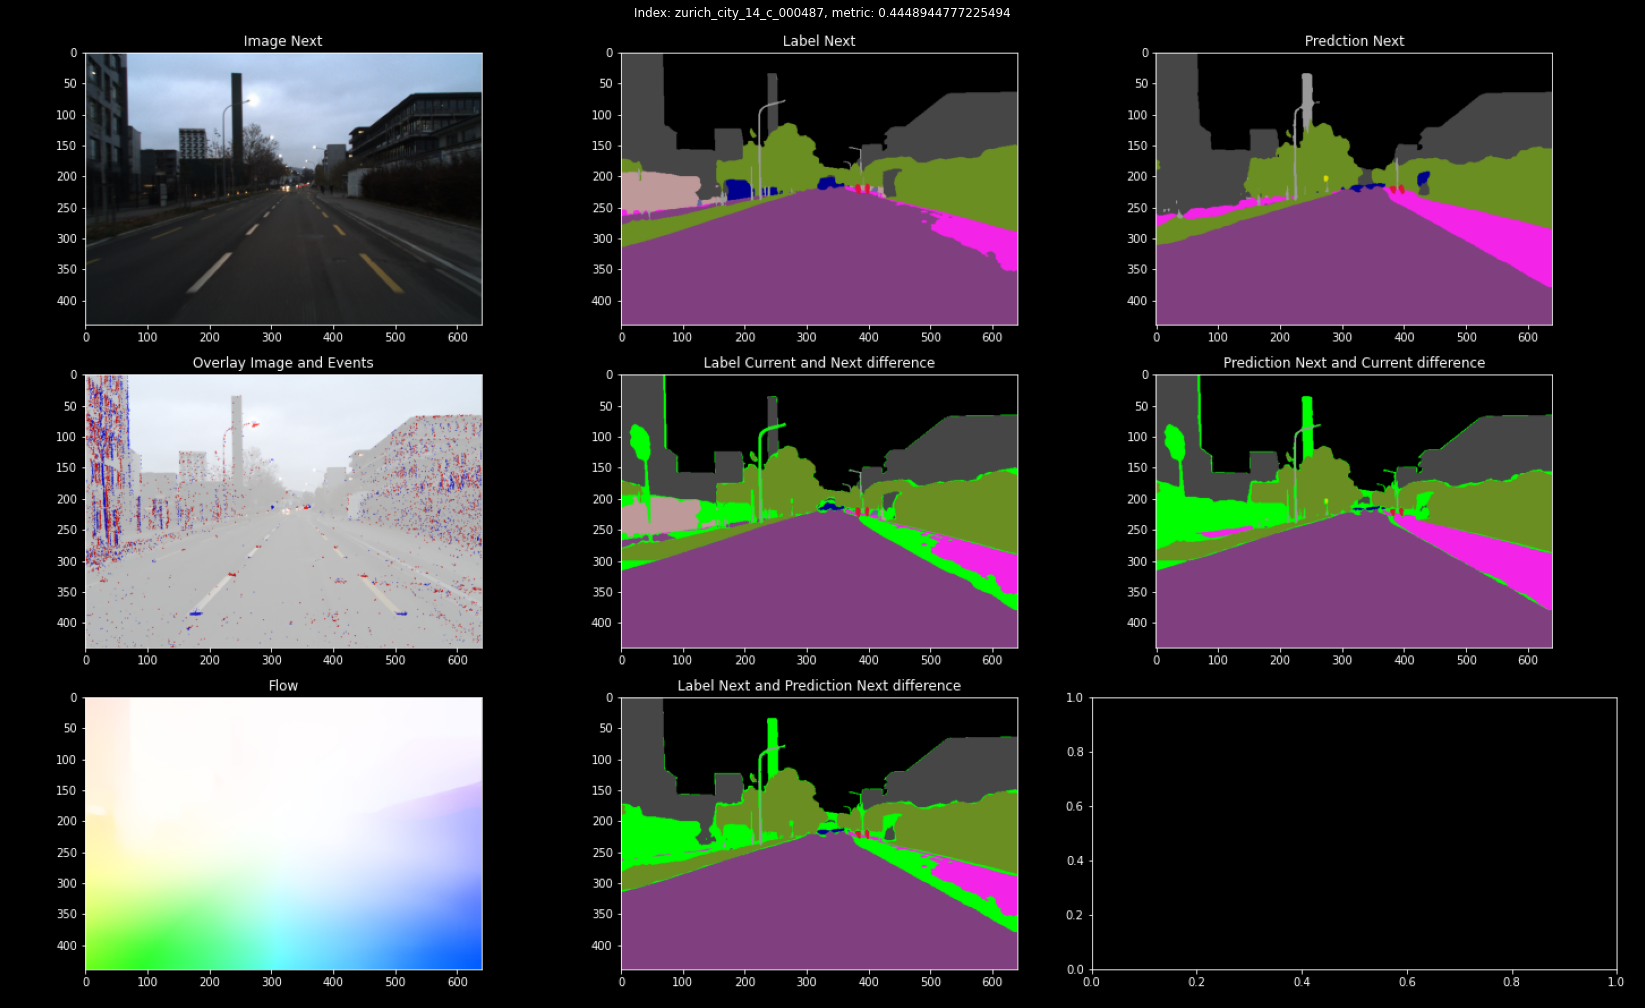

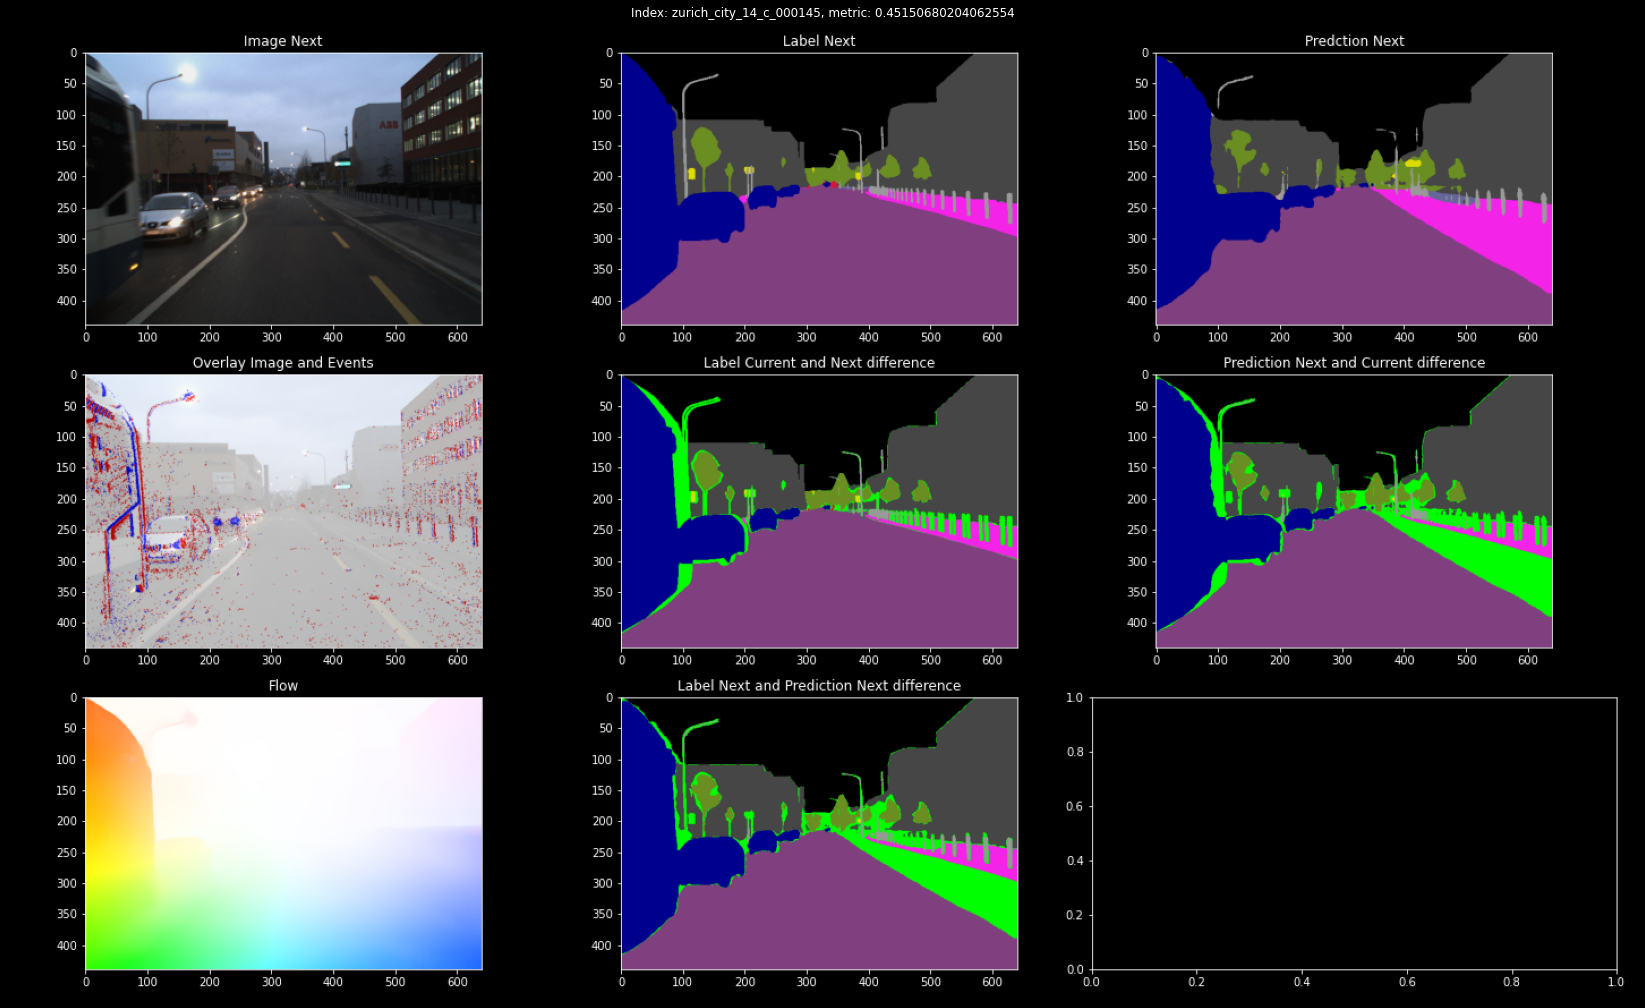

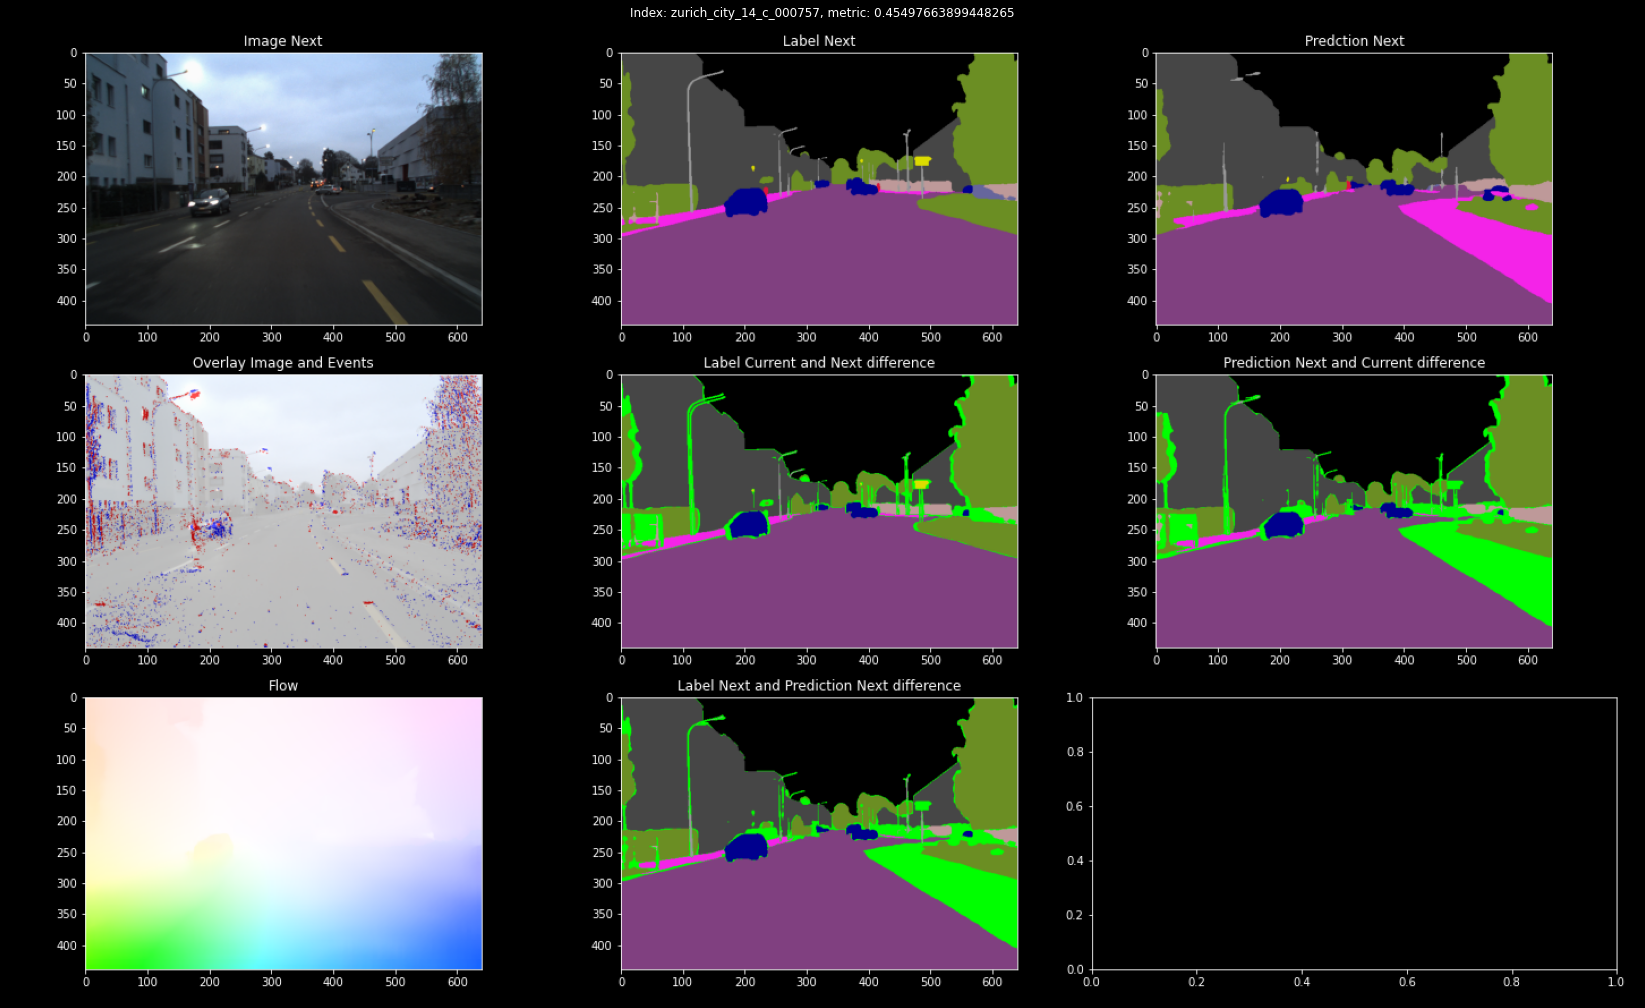

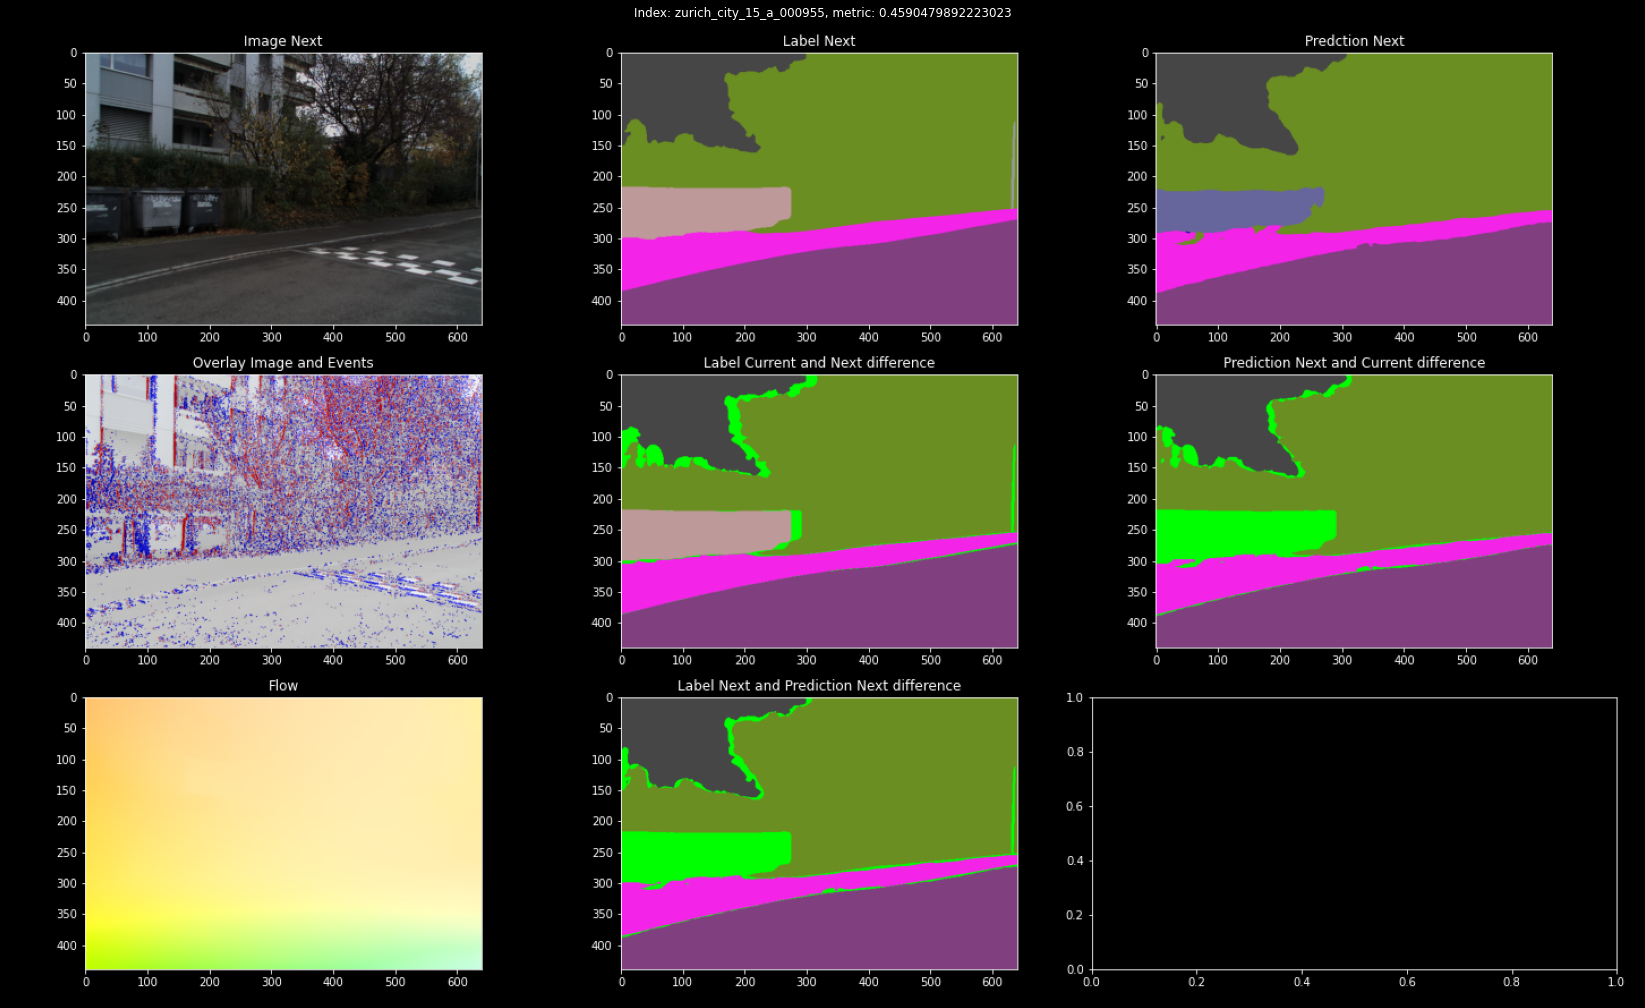

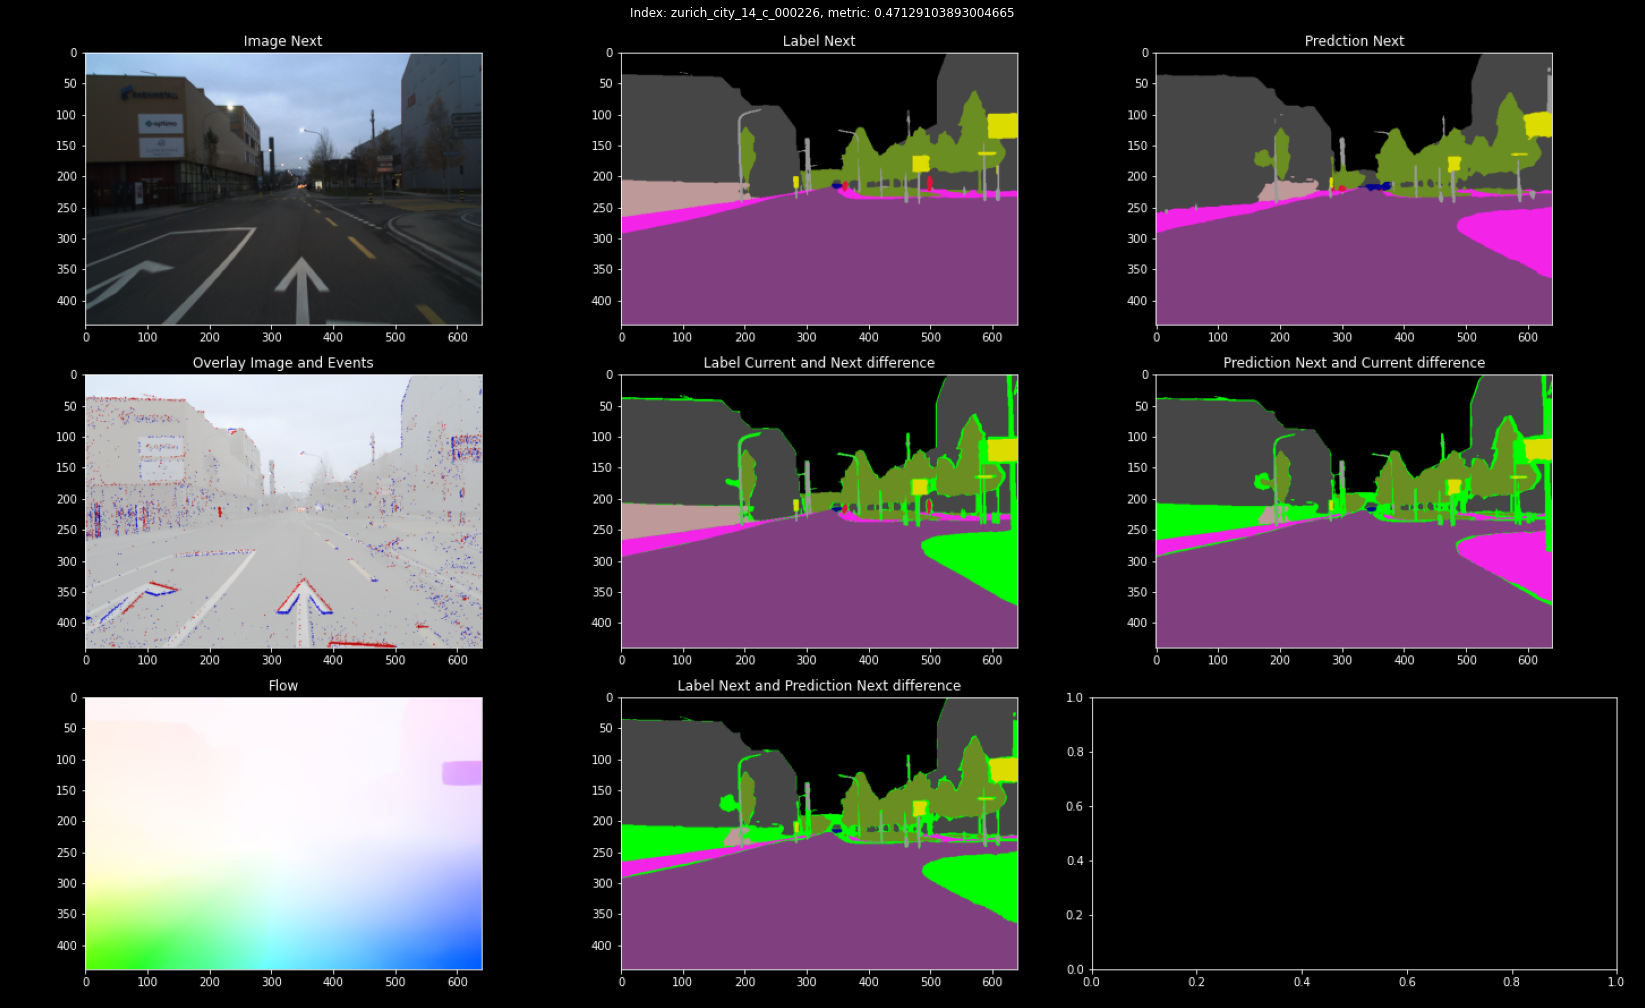

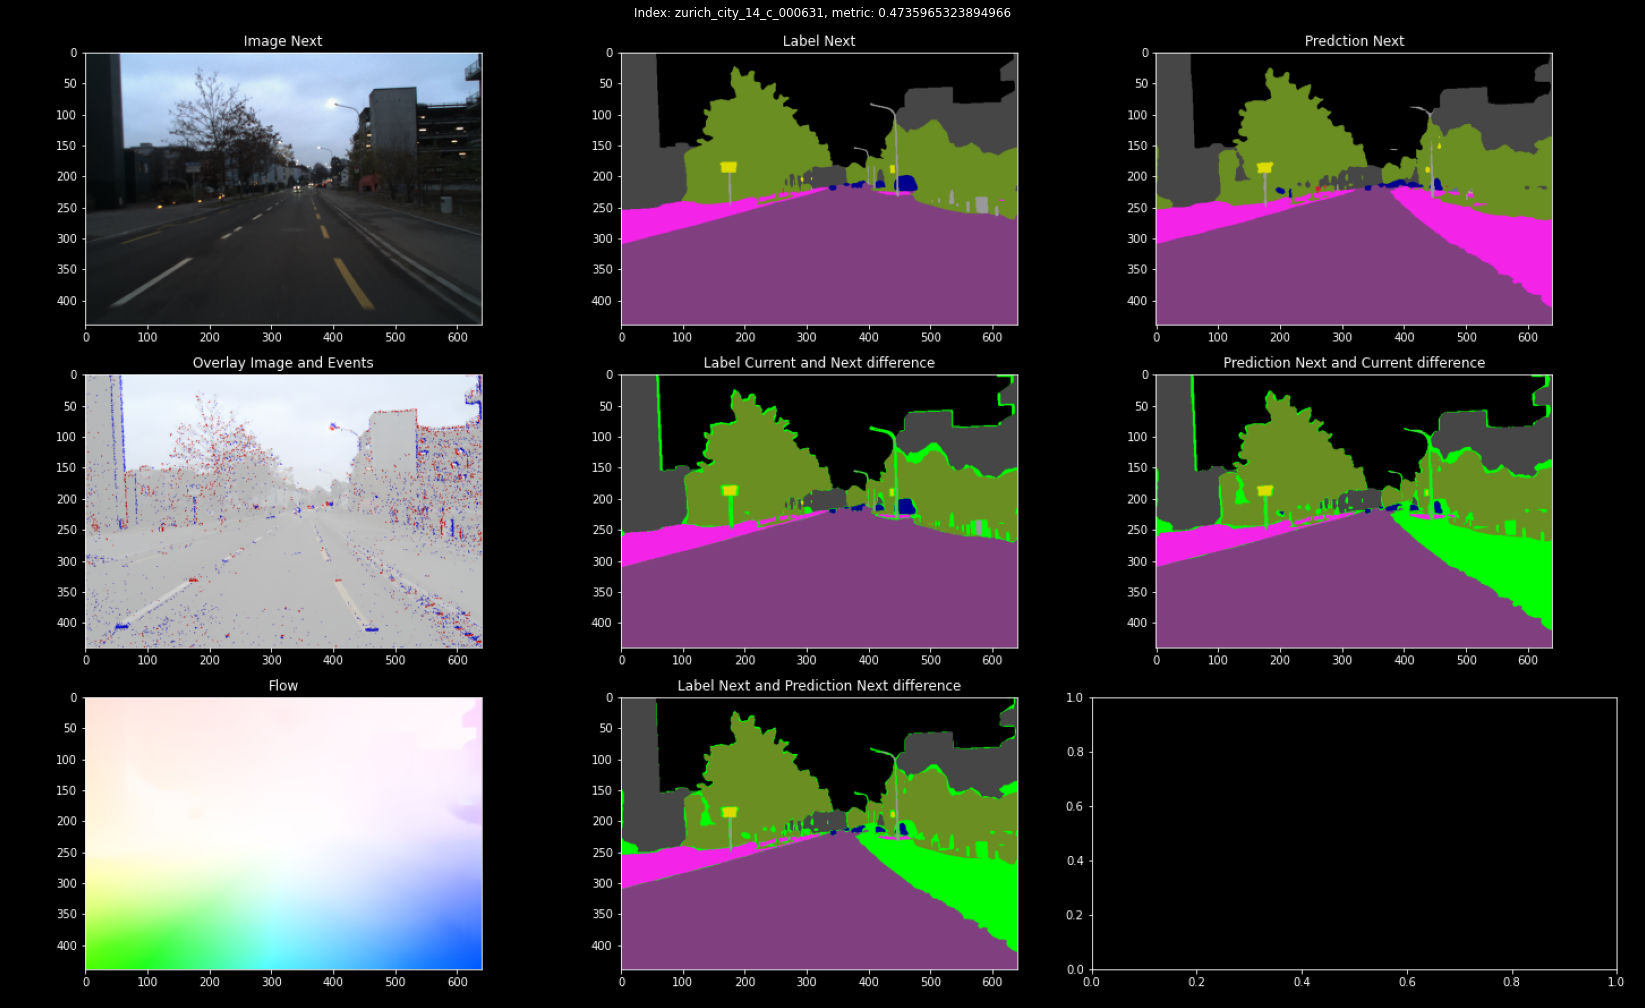

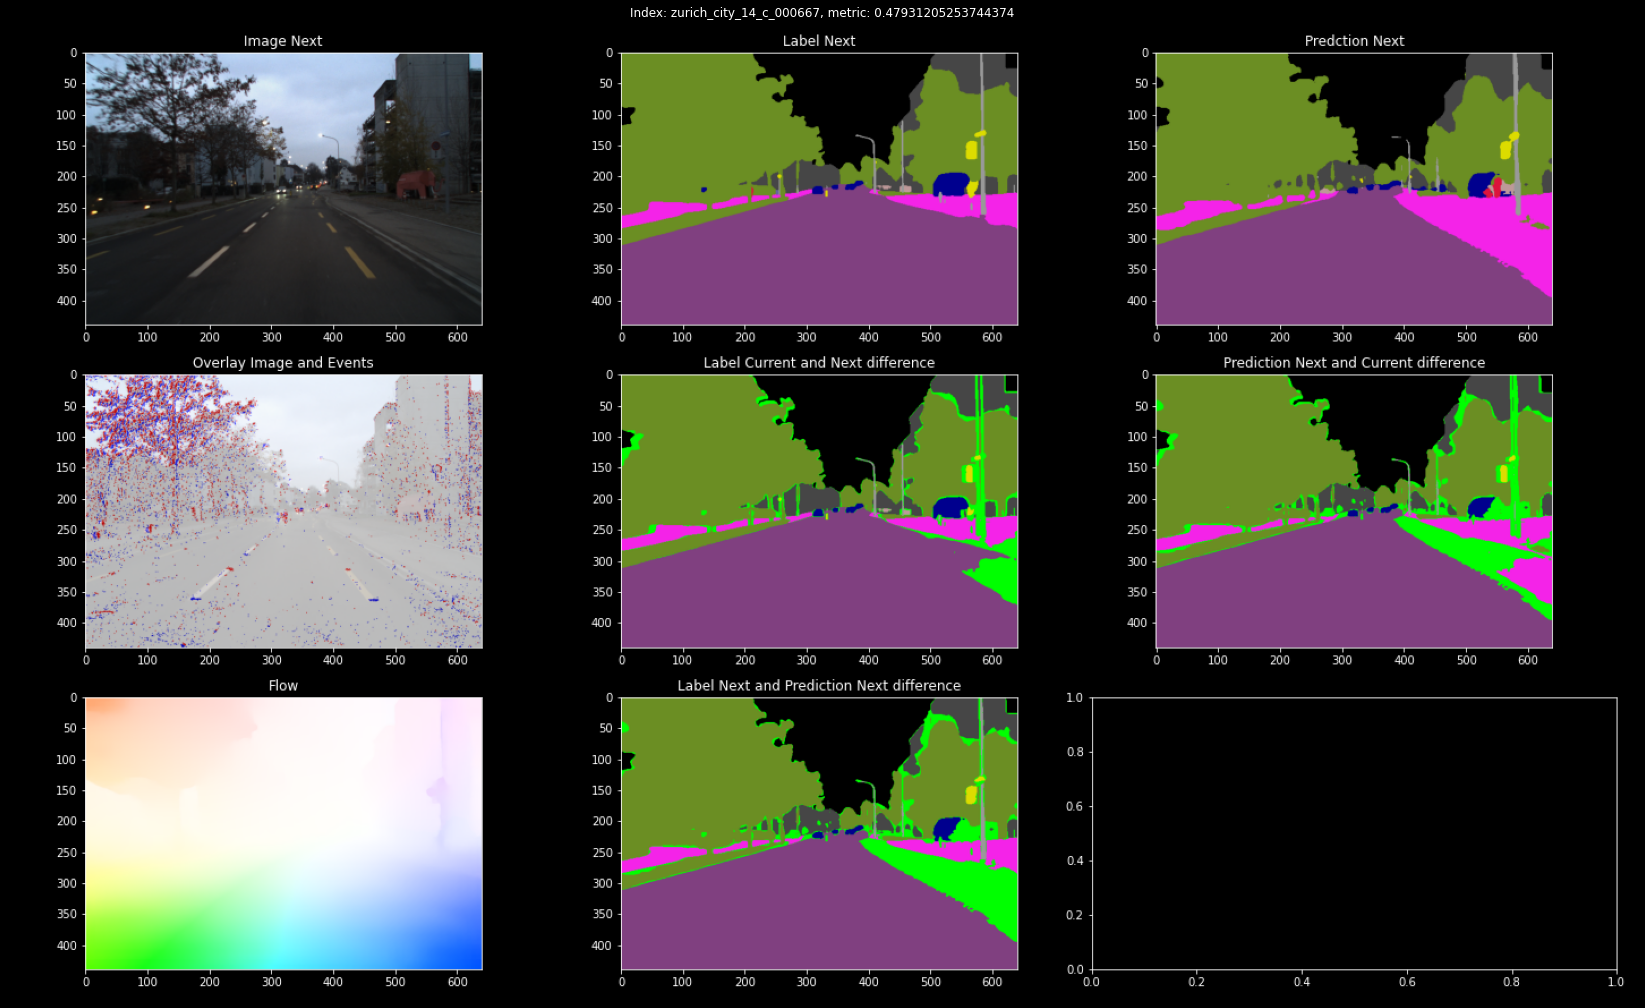

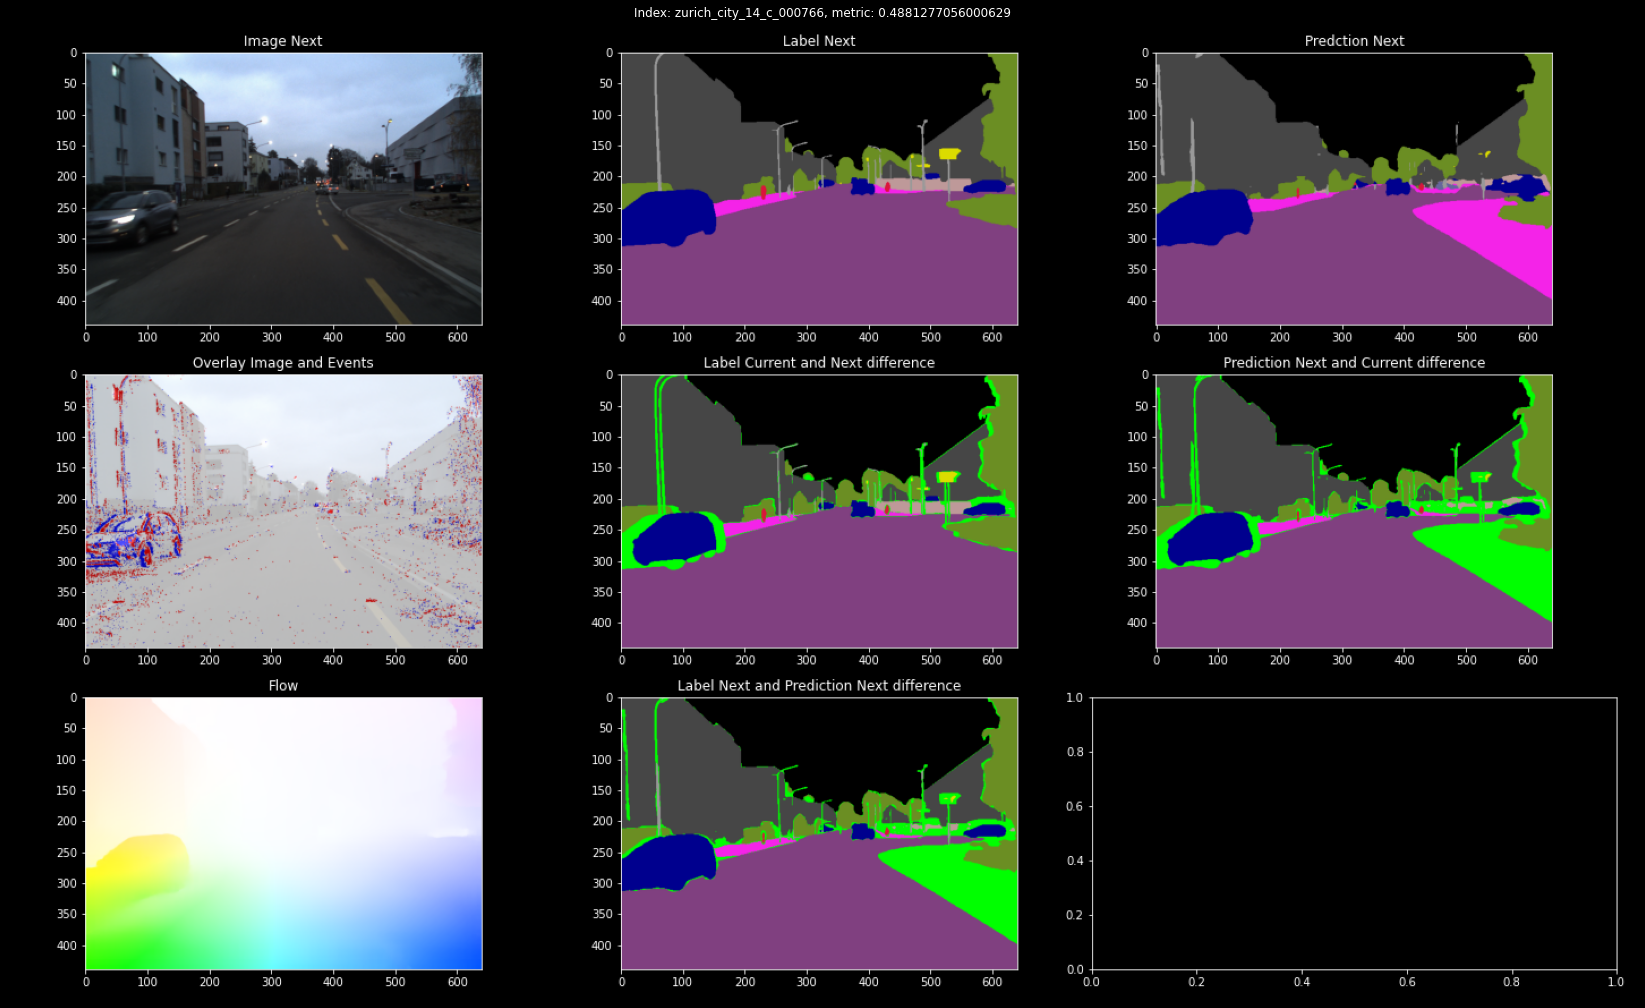

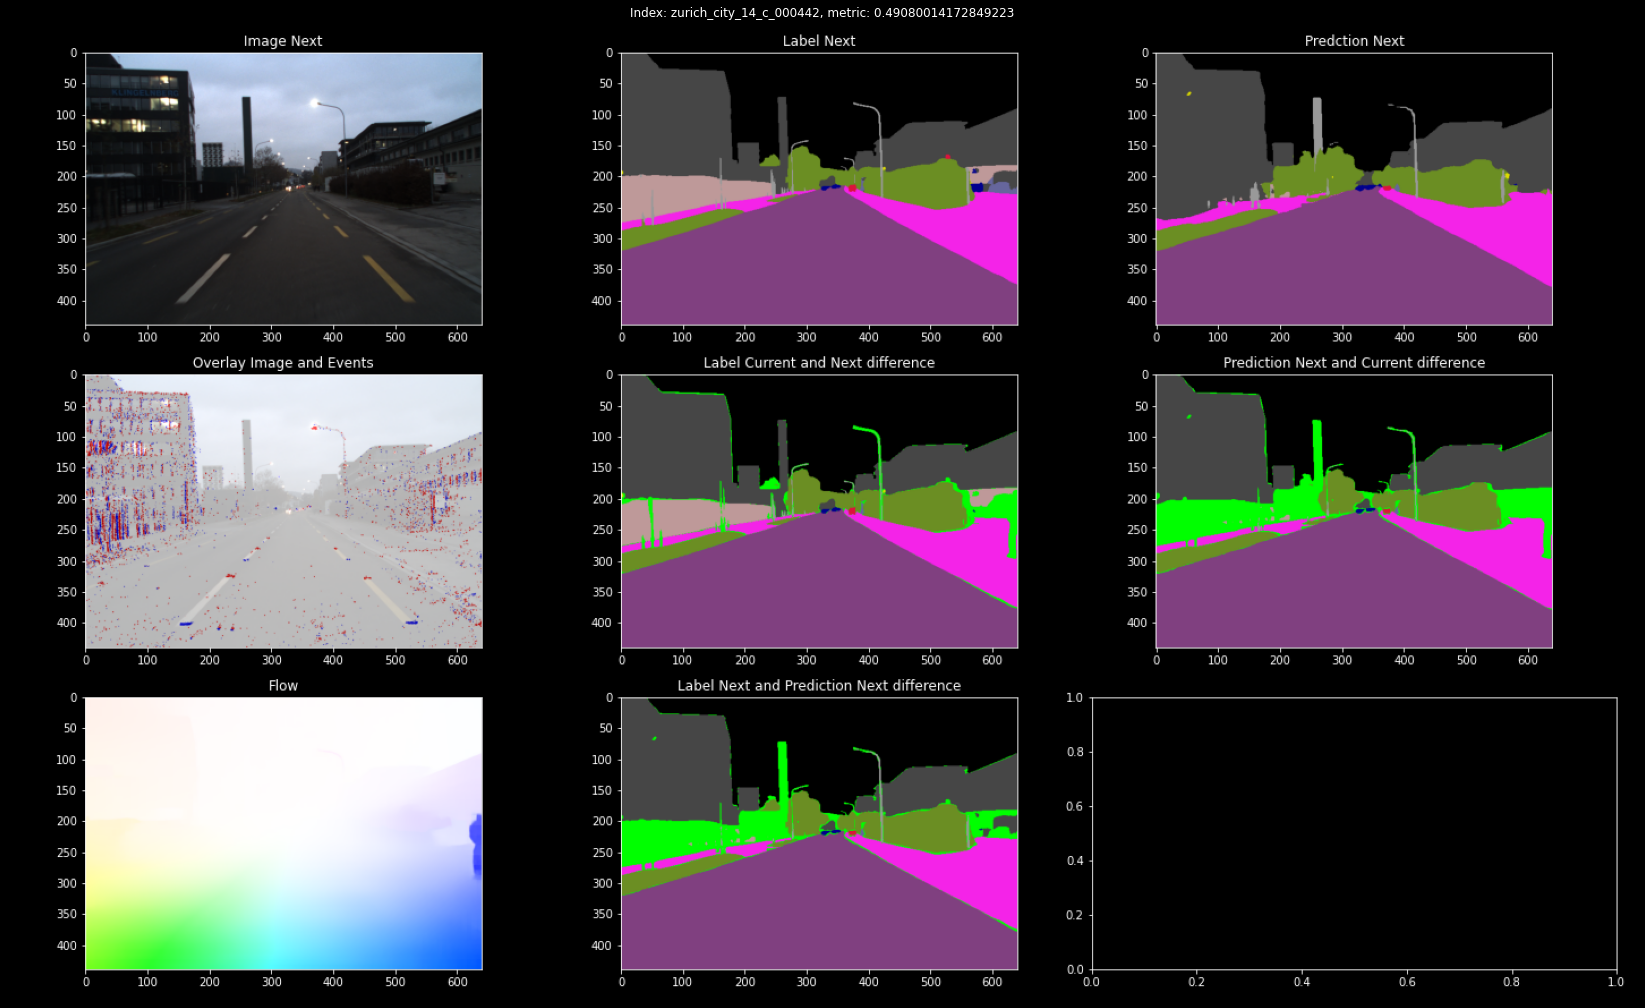

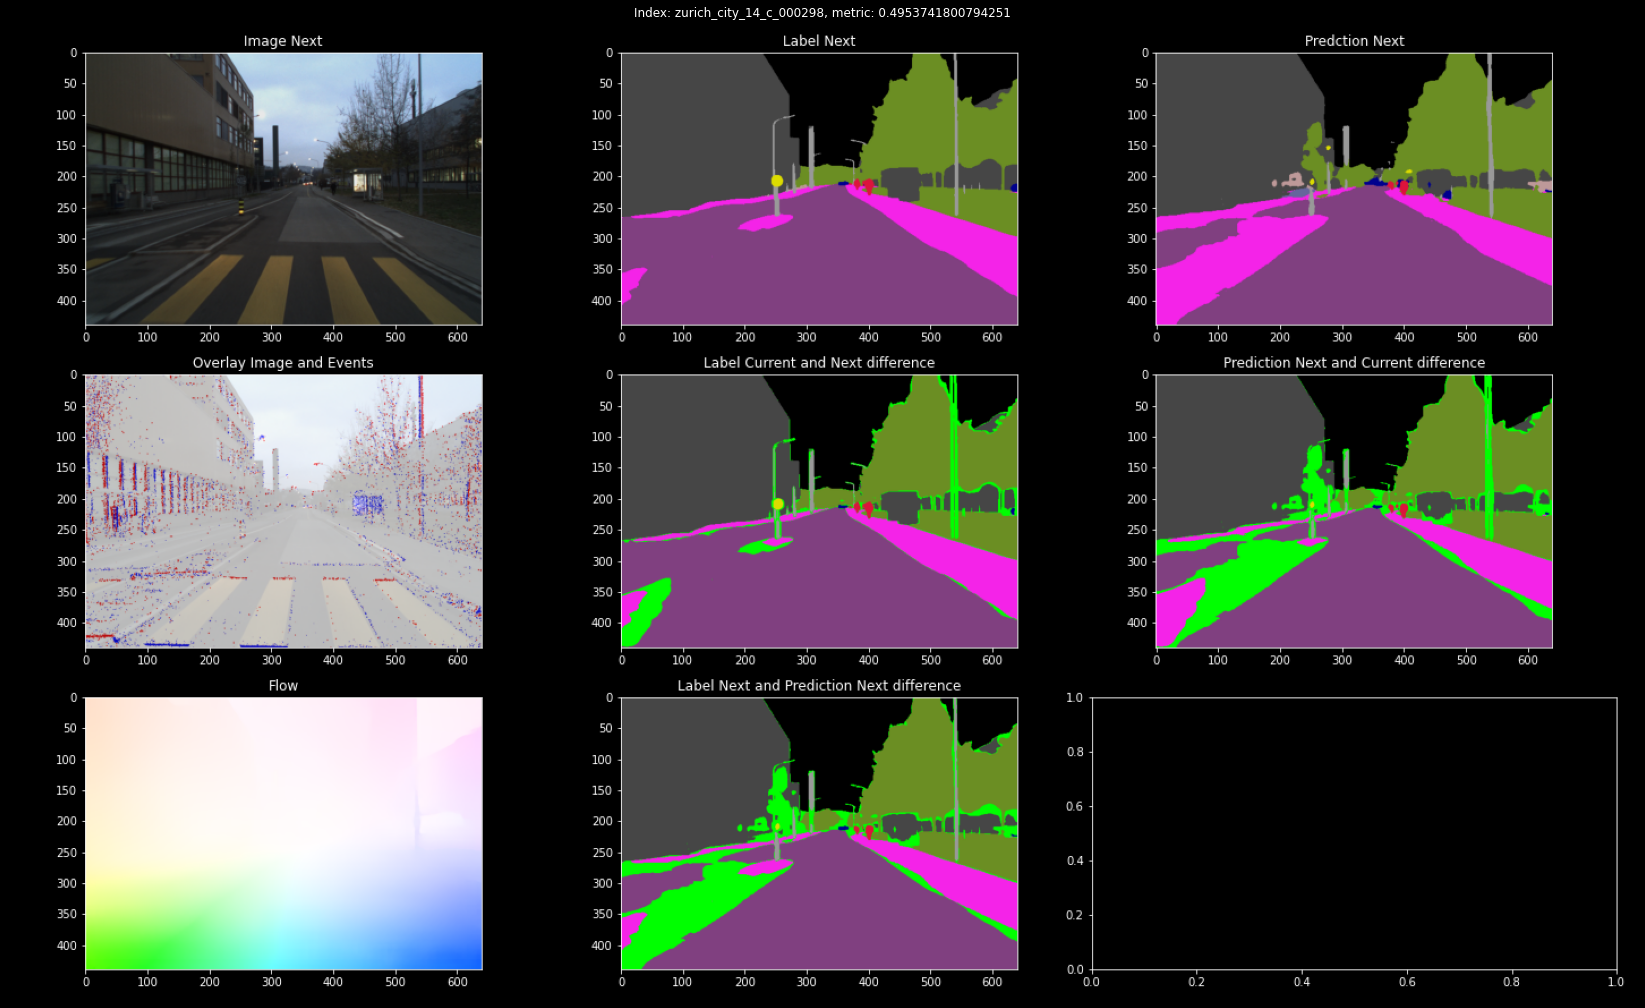

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

for worst_metric_image in worst_metric_images:
    idx, metric = worst_metric_image
    filename = '/home/xiaoshan/work/adap_v/DELIVER/visualize/' + idx + '.png'
    # read and display the image
    img = Image.open(filename)
    plt.figure(figsize=(30, 18))  # Set the figure size to 10x10 inches
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Index: {idx}, metric: {metric}')
    plt.show()